In [27]:
import numpy as np
import pandas as pd
import doubleml as dml

from sklearn.ensemble import RandomForestClassifier

In [28]:
def f_loc(D, X):
  loc = 2*D + 2*D*X[:,4]*2*X[:,1] - 3*X[:,3]
  return(loc)

def f_scale(D,X):
  scale = np.sqrt(0.5*D + 3*D*X[:,1] + 1)
  return(scale)


def dgp(n=200, p=5):
    X = np.random.uniform(0,1,size=[n,p])
    D = (( X[:,1 ] - 0.5 + X[:,3] + np.random.normal(size=n)) > 0)*1.0
    D = ((np.random.normal(size=n)) > 0)*1.0
    epsilon = np.random.normal(size=n)

    Y = f_loc(D, X) + f_scale(D, X)*epsilon

    return Y, X, D, epsilon

In [29]:
tau_vec = np.arange(0.2,0.9,0.1)
n_true = 1000000


_, X_true, _, epsilon_true = dgp(n=n_true)
D1 = np.ones(n_true)
D0 = np.zeros(n_true)

Y1 = f_loc(D1, X_true) + f_scale(D1, X_true)*epsilon_true
Y0 = f_loc(D0, X_true) + f_scale(D0, X_true)*epsilon_true

Y1_quant = np.quantile(Y1, q=tau_vec)
Y0_quant = np.quantile(Y0, q=tau_vec)

QTE = Y1_quant - Y0_quant

In [30]:
R=100
n=500
p=5

ml_m = RandomForestClassifier(n_estimators=100)
ml_g = RandomForestClassifier(n_estimators=100)

QTE_est = np.full((R, len(tau_vec)), np.nan)

ci_QTE = np.full((R, len(tau_vec), 2), np.nan)
coverage = np.full((R, len(tau_vec)), np.nan)
for rep in range(R):
    Y, X, D, _ = dgp(n=n,p=p)
    obj_dml_data = dml.DoubleMLData.from_arrays(X, Y, D)

    dml_QTE = dml.DoubleMLQTE(obj_dml_data,
                      ml_g, ml_m,
                      quantiles=tau_vec,
                      n_rep=1,
                      n_folds=5)
    dml_QTE.fit()

    ci_QTE[rep, :, :] = dml_QTE.confint(level=0.95).to_numpy()
    QTE_est[rep, :] = dml_QTE.coef

    coverage[rep, :] = (ci_QTE[rep, :, 0] <= QTE) & (ci_QTE[rep, :, 1] >= QTE)

In [31]:
print(f"Coverage QTE: {coverage.mean(0)}")

Coverage QTE: [0.38 0.45 0.47 0.43 0.5  0.31 0.4 ]


In [32]:
data = {"Quantile": tau_vec, "QTE": QTE, "DML QTE": QTE_est.mean(0),
        "DML QTE lower": ci_QTE.mean(0)[:, 0], "DML QTE upper": ci_QTE.mean(0)[:, 1]}
df = pd.DataFrame(data)
print(df)

   Quantile       QTE   DML QTE  DML QTE lower  DML QTE upper
0       0.2  2.363264  2.368211       2.238666       2.497756
1       0.3  2.564961  2.571287       2.441742       2.700832
2       0.4  2.741506  2.748258       2.618713       2.877803
3       0.5  2.915563  2.905293       2.775747       3.034838
4       0.6  3.099904  3.084898       2.955353       3.214443
5       0.7  3.314519  3.278178       3.148633       3.407723
6       0.8  3.599286  3.522808       3.393262       3.652353


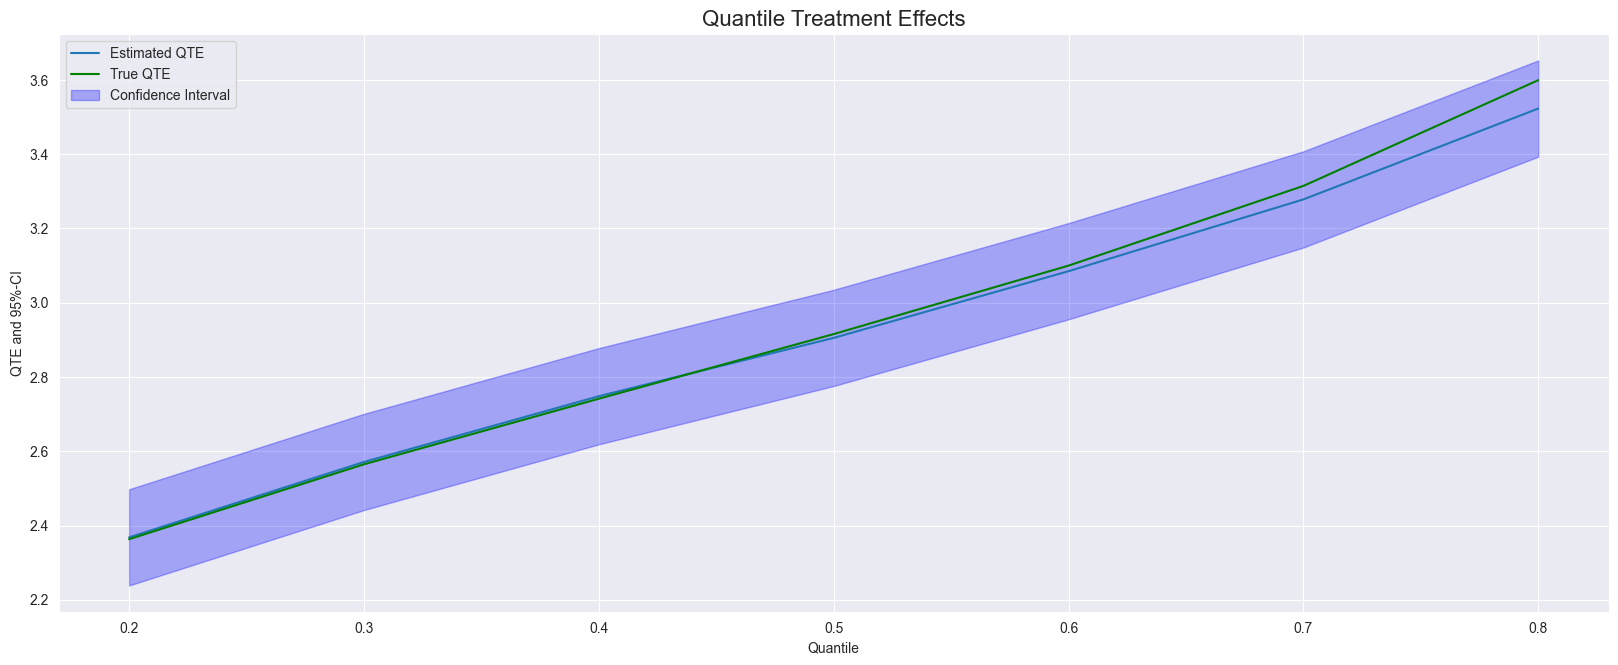

In [33]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 20., 7.5
fig, ax = plt.subplots()

ax.plot(df['Quantile'],df['DML QTE'], label='Estimated QTE')
ax.plot(df['Quantile'],df['QTE'], color="green", label='True QTE')
ax.fill_between(df['Quantile'], df['DML QTE lower'], df['DML QTE upper'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('Quantile Treatment Effects', fontsize=16)
plt.xlabel('Quantile')
_ =  plt.ylabel('QTE and 95%-CI')